In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from entities import Title

In [2]:
def match_mangas(source_df, target_df, target_df_name_columns: list, target_df_name: str):
    
    # create manga titles
    ru_names = source_df.name.tolist()
    an_names = source_df.original_name.tolist()
    en_names = source_df.eng_name.tolist()
    ids = source_df.index.tolist()
    gtitles = [Title([ru_names[i], an_names[i], en_names[i]], meta={'index': ids[i]}) for i in range(len(ru_names))]
    
    target_manga_names = list(target_df[target_df_name_columns].to_records(index=False))
    ids = target_df.index.tolist()
    mtitles = [Title(list(target_manga_names[i]), meta={'index': ids[i]}) for i in range(len(target_manga_names))]

    print('source titles n:', len(gtitles))
    print('target titles n:', len(mtitles))
    
    matched = []
    q_matches = []
    source_df.loc[:, f'{target_df_name}_id'] = None
    source_df.loc[f'n_duplicates_{target_df_name}'] = 0

    for i, gtitle in tqdm(enumerate(gtitles), total=len(gtitles)):
        matches = 0
        for j, mtitle in enumerate(mtitles):

            if mtitle is None:
                continue

            if mtitle == gtitle:
                if matches > 0:
                    matched[-1].append(mtitle)
                else:
                    matched.append([gtitle, mtitle])
                matches += 1


        if matches == 1:
            # if and only one2one corresponding found
            mtitle = matched[-1][-1]
            source_df.loc[i, f'{target_df_name}_id'] = mtitle.get_index()

        elif matches > 1:
            # search the most similar
            g_index = gtitle.get_index()
            curr_matched = matched[-1]
            n_similars = [gtitle.strong_equal_names_n(mtitle) for mtitle in curr_matched[1:]]
            if n_similars.count(max(n_similars)) > 1:
                # if more then 1 top similar
                top_similars_recorded = 0
                for k, (n_sim, item) in enumerate(zip(n_similars, curr_matched[1:])):
                    if n_sim == max(n_similars) and top_similars_recorded == 0:
                        source_df.loc[g_index, f'{target_df_name}_id'] = item.get_index()
                    elif n_sim == max(n_similars):
                        source_df.loc[g_index, f'{target_df_name}_id_%d' % top_similars_recorded] = item.get_index()
                    top_similars_recorded += 1
                source_df.loc[g_index, f'n_duplicates_{target_df_name}'] = top_similars_recorded
            else:
                # if 1 similar
                top_simimlar_ix = n_similars.index(max(n_similars))
                top_similar_item = curr_matched[1:][top_simimlar_ix]
                source_df.loc[g_index, f'{target_df_name}_id'] = top_similar_item.get_index()

        q_matches.append(matches)
        
    return {'q_matches': q_matches,
            'source_df': source_df,
            'matched': matched}

# Match remanga

In [3]:
remanga = pd.read_csv('./data/raw/remanga_catalog_full.csv')
remanga.head(2)

,rus_name,en_name,issue_year,avg_rating,total_views,total_votes,type,dir,n_chapters
0,Поднятие уровня в одиночку,Solo Leveling,2018.0,9.6,9546754,1210457,Манхва,solo-leveling,151.0
1,Начало после конца,The Beginning After the End,2018.0,9.6,6130139,1172388,Западный комикс,the_beginning_after_the_end,107.0


## With readmanga

In [4]:
gmanga = pd.read_csv('./data/raw/manga.csv', sep=';')
gmanga.head(2)

,id,name,eng_name,original_name,another_names,chapters_count
0,1,Ван Пис,One Piece,One Piece,Budak Getah / Большой Куш / ワンピース / Один Кусок,1028
1,2,Наруто,Naruto,Naruto,ナルト,704


In [ ]:
res_gmanga_rm = match_mangas(gmanga, remanga, ['rus_name', 'en_name'], 'remanga')
gmanga = res_gmanga_rm['source_df']

source titles n: 20825
target titles n: 16899


In [ ]:
gmanga.to_csv('data/gmanga_matched_remanga_ids.csv', sep=';')

In [ ]:
_ = plt.hist(q_matches)

## With mintmanga

In [ ]:
gmint = pd.read_csv('./data/raw/mint.csv', sep=';')
print(gmint.shape)
gmint.head()

In [ ]:
res_gmint_rm = match_mangas(gmint, remanga, ['rus_name', 'rn_name'], 'remanga')
gmint = res_gmint_rm['source_df']

In [ ]:
gmint.to_csv('data/gmint_matched_remanga_ids.csv', sep=';', index=False)

In [ ]:
_ = plt.hist(q_matches)

# Match mangalib

In [3]:
mangalib = pd.read_csv('./data/raw/mangalib_catalog_titles.csv')
print(mangalib.shape)
mangalib.head()

(1800, 5)


,id,link,data_id,manga_type,name
0,0,i-alone-level-up,7580,Манхва,Поднятие уровня в одиночку
1,1,you-are-here,4291,Маньхуа,Ты здесь
2,2,poidyom-gulyat,67688,Руманга,Пойдём гулять!
3,3,the-beginning-after-the-end,6478,OEL-манга,Начало после конца
4,4,19-tian,1886,Маньхуа,19 Дней - Однажды


## with readmanga

In [4]:
gmanga = pd.read_csv('data/gmanga_matched_remanga_ids.csv', sep=';')
print(gmanga.shape)

(20826, 12)


In [5]:
res_gmanga_mangalib = match_mangas(gmanga, mangalib, ['name'], 'mangalib')
gmanga = res_gmanga_mangalib['source_df']

source titles n: 20826
target titles n: 1800


In [6]:
gmanga.to_csv('./data/gmanga_matched_remanga_mangalib_ids.csv', sep=';', index=False)

In [7]:
_ = plt.hist(q_matches)

NameError: name 'q_matches' is not defined

## with mintmanga

In [8]:
gmint = pd.read_csv('data/gmint_matched_remanga_ids.csv', sep=';')
gmint.head(2)

,id,name,eng_name,original_name,another_names,chapters_count,remanga_id,remanga_id_1,n_duplicates
0,11,Денег нет!,No money,Okane ga nai,お金がないっ / 午夜情深 / 没有钱,116,9766.0,NaN,NaN
1,18,Проклятие цвета крови,Crimson Spell,Crimson Spell,Kurimuzon Superu/クリムゾン・スペル/緋紅色的魔咒/緋色誘惑,75,10537.0,NaN,NaN


In [9]:
res_gmint_mangalib = match_mangas(gmint, mangalib, ['name'], 'mangalib')
gmint = res_gmint_mangalib['source_df']

source titles n: 13655
target titles n: 1800


In [10]:
gmint.to_csv('data/gmint_matched_remanga_mangalib_ids.csv', sep=';', index=False)

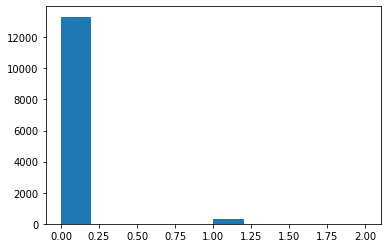

In [11]:
_ = plt.hist(res_gmint_mangalib['q_matches'])

In [ ]:
2+2